orgin: http://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html  
translator: Hongpu Liu

In [1]:
%matplotlib inline
from __future__ import division, print_function

# STN（Spatial Transformer Networks）教程
![](imgs/FSeq.png)

在本教程中，我们将学习如何利用一种叫做空间变换网络（STN）的视觉注意力机制来增强你的网络。你可以阅读[DeepMind 论文](https://arxiv.org/abs/1506.02025)获得更多关于STN的信息。

空间变换网络可以让神经网络学到如何在输入图像上执行空间变换，以利于增强模型的几何不变性。例如，它可以截取图像中感兴趣的区域、缩放图像和修正图像朝向。由于CNNs主要在做仿射变换，对旋转和缩放不具不变性，因此这一机制非常有用。

只需对现有的CNN稍加改变，就可以把STN的能力加入到其中。

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion() # 交互模式

## 1. 加载数据
在本例中，我们将在经典的MNIST数据集上进行实验，并用STN来增强一个标准的卷积神经网络。

In [3]:
use_cuda = torch.cuda.is_available()

# 训练数据集
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)

# 测试数据集
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

## 2. STN的结构
空间变换网络包含三个主要组件：
- **Localization Networks**是一个规则的CNN，用于回归变换参数。变换参数并不是显式的从数据集中学到的，而是从增强整个网络的精确度的过程中自动学到的空间变换。
- **Grid generator**生成输入图像到输出图像之前的对应坐标。
- **Sampler**使用变换参数并应用于输入图像。

![](imgs/stn-arch.png)

> **注意**
> 只有最近的PyTorch版本才包含了**affine_grid**和**grid_sample**模块

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
        # 定位网络
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        
        # 生成 3 * 2 仿射矩阵的回归器
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        
        # 用单位变换初始化fc_loc的权重和偏差
        self.fc_loc[2].weight.data.fill_(0)
        self.fc_loc[2].bias.data = torch.FloatTensor([1, 0, 0, 0, 1, 0])
        
    # STN的前馈过程
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)       
        
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x
    
    # 前馈
    def forward(self, x):
        # 将输入进行变换
        x = self.stn(x)
        
        # 执行正常的前馈传播
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
model = Net()
if use_cuda:
    model.cuda()

## 3. 训练模型
现在，用SDG算法来训练模型。网络在监督模式下学习分类任务。同时，模型自动的以端到端的形式学习STN。

In [5]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
            
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
            
# 用于评估STN性能的测试子程序
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        
        # 把批量损失进行相加
        test_loss += F.nll_loss(output, target, size_average=False).data[0]
        # 获得最大对数概率的索引
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'
          .format(test_loss, correct, len(test_loader.dataset),
                  100. * correct / len(test_loader.dataset)))

## 4. 可视化STN的结果
现在，我们要观察视觉注意力机制学习到的结果。

我们定一个函数用于可视化训练时的变换。

In [6]:
def convert_image_np(inp):
    """将Tensor转换为numpy图像"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# 我们想要对训练后的空间变换层进行可视化，我们要可视化一个批量的输入图像和对应的STN的输出

def visualize_stn():
    # 获得一组训练数据
    data, _ = next(iter(test_loader))
    data = Variable(data, volatile=True)
    
    if use_cuda:
        data = data.cuda()
    
    input_tensor = data.cpu().data
    transformed_input_tensor = model.stn(data).cpu().data
    
    in_grid = convert_image_np(
        torchvision.utils.make_grid(input_tensor))
    
    out_grid = convert_image_np(
        torchvision.utils.make_grid(transformed_input_tensor))
    
    # 绘制结果图表
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(in_grid)
    axarr[0].set_title('Dataset Images')
    
    axarr[1].imshow(out_grid)
    axarr[1].set_title('Transformed Images')

In [7]:
import time
for epoch in range(1, 20 + 1):
    since = time.time()
    train(epoch)
    time_elapsed = time.time() - since
    print('Epoch[{}]:\tTime used {:.0f}m {:.0f}s'.format(
        epoch, time_elapsed // 60, time_elapsed % 60))    
    
    since = time.time()
    test()
    time_elapsed = time.time() - since
    print('Time used {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))   

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320795
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.824064
Epoch[1]:	Time used 0m 35s

Test set: Average loss: 0.2054, Accuracy: 9401/10000 (94%)
Time used 0m 3s

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.382738
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.447043
Epoch[2]:	Time used 0m 35s

Test set: Average loss: 0.1473, Accuracy: 9538/10000 (95%)
Time used 0m 3s

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.382607
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.234277
Epoch[3]:	Time used 0m 35s

Test set: Average loss: 0.0936, Accuracy: 9705/10000 (97%)
Time used 0m 3s

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.419678
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.137366
Epoch[4]:	Time used 0m 36s

Test set: Average loss: 0.3676, Accuracy: 8775/10000 (88%)
Time used 0m 3s

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.470891
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.178054
Epoch[5]:	Time used 0m 37s

Test set: Average loss: 0.0698, Accuracy: 9784/10000 (98%)
Time used 0m 3s

Train

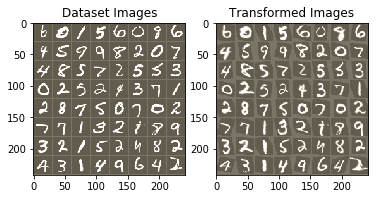

In [9]:
# 可视化一组输入经过STN变换后的差异
visualize_stn()